In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

So, there are three targets:

Age: range from 1 to 116 <br>
Ethnicity: 0 - White, 1 - Black, 2 - Asian, 3 - Indian, 4 - Other  <br>
Gender: 0 - male, 1 - female <br>

In [2]:
df = pd.read_csv('age_gender.csv')

In [3]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


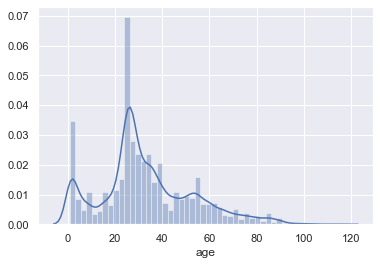

In [5]:
# Age
sns.distplot(df['age']);

So there are some outliers, let's take a look closer.

In [6]:
# Check 99 percentile
np.percentile(df['age'], 99)

87.0

In [7]:
len(df[df['age'] > 87])

236

There are 236 outliers, for better generalization I will leave only 99% of data.

In [8]:
df = df[df['age'] < 87]

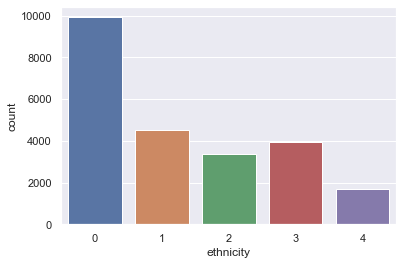

In [9]:
# Ethnicity
sns.countplot(df['ethnicity']);

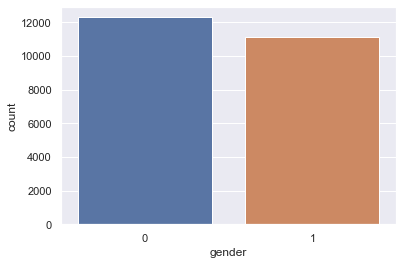

In [10]:
# Gender
sns.countplot(df['gender']);

Actually id dataset pixels are in string format, let's transform it in more useful type of data.

In [11]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

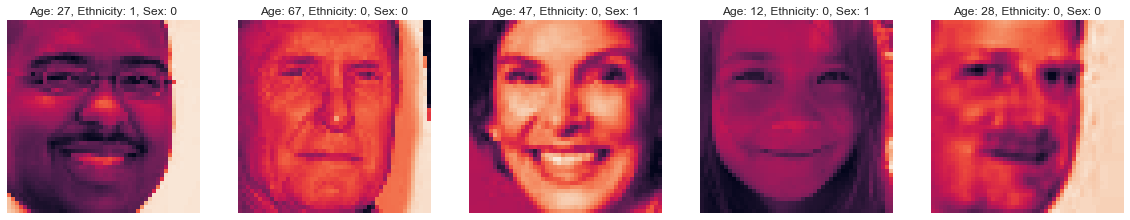

In [12]:
# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    ethnicity = df['ethnicity'][random_face]
    gender = df['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(df['pixels'][random_face])
    axes[i].axis('off')


## CNN

In [13]:
# Reshape images for CNN
X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)

In [14]:
# Normalise images
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255

In [15]:
# Set some useful variables
input_shape = X_reshaped.shape[1:] 

n_epochs = 25
batch_size = 64

## Age prediction

So let's start with age prediction. 

In [16]:
# Set y
y = df['age'].values

In [17]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [18]:
age_model = Sequential()

age_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(BatchNormalization())

age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
#age_model.add(Dropout(0.4))
age_model.add(BatchNormalization())

age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.5))
age_model.add(BatchNormalization())

age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.4))
age_model.add(Dense(1))

age_model.compile(optimizer='adam', loss='mse')

age_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         2

In [19]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1)]

In [20]:
history = age_model.fit(X_train, y_train, 
                        epochs=n_epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/25
294/294 [==============================] - 155s 528ms/step - loss: 206.3617 - val_loss: 1623.7712 - lr: 0.0010
Epoch 2/25
294/294 [==============================] - 151s 513ms/step - loss: 123.7436 - val_loss: 543.9988 - lr: 0.0010
Epoch 3/25
294/294 [==============================] - 149s 508ms/step - loss: 108.4756 - val_loss: 126.0704 - lr: 0.0010
Epoch 4/25
294/294 [==============================] - 154s 522ms/step - loss: 98.5564 - val_loss: 131.4881 - lr: 0.0010
Epoch 5/25
294/294 [==============================] - ETA: 0s - loss: 92.3712
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
294/294 [==============================] - 159s 542ms/step - loss: 92.3712 - val_loss: 285.7446 - lr: 0.0010
Epoch 6/25
294/294 [==============================] - 163s 553ms/step - loss: 78.4832 - val_loss: 69.6357 - lr: 1.0000e-04
Epoch 7/25
294/294 [==============================] - 151s 513ms/step - loss: 72.0336 - val_loss: 65.8824 - lr: 1.0000e-04
Ep

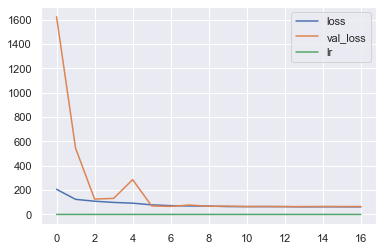

In [21]:
pd.DataFrame(history.history).plot();

In [22]:
# 
valid_score = age_model.evaluate(X_test, y_test, verbose=1)

147/147 [==============================] - 10s 70ms/step - loss: 64.9731


In [23]:
# Make predictions 
y_pred = age_model.predict(X_test)

In [24]:
# Man absolute error
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 5.777898868985747


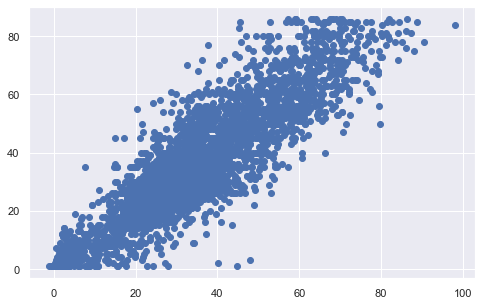

In [25]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, y_test);

So, mean absolute error around 5.5 years it's not so super result considering mean age is 33, it's about 17%.

## Gender prediction

In [26]:
# Set y
y = df['gender'].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [27]:
gender_model = Sequential()

gender_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
#gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.4))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.5))
gender_model.add(BatchNormalization())

gender_model.add(Flatten())

gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.4))

gender_model.add(Dense(1, activation='sigmoid')) #For binary classification activation function is sigmoid 

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #...and loss function is binary_crossentropy

gender_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 128)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 10, 128)      

In [28]:
# Callbacks for gender model
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1)]

In [29]:
history = gender_model.fit(X_train, y_train, 
                           epochs=n_epochs,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

Epoch 1/25
294/294 [==============================] - 196s 667ms/step - loss: 0.4835 - accuracy: 0.7715 - val_loss: 1.0531 - val_accuracy: 0.5179 - lr: 0.0010
Epoch 2/25
294/294 [==============================] - 197s 671ms/step - loss: 0.3457 - accuracy: 0.8453 - val_loss: 0.4139 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 3/25
294/294 [==============================] - 198s 672ms/step - loss: 0.3069 - accuracy: 0.8649 - val_loss: 0.3343 - val_accuracy: 0.8429 - lr: 0.0010
Epoch 4/25
294/294 [==============================] - 193s 657ms/step - loss: 0.2853 - accuracy: 0.8738 - val_loss: 0.2909 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 5/25
294/294 [==============================] - 192s 654ms/step - loss: 0.2738 - accuracy: 0.8789 - val_loss: 0.3374 - val_accuracy: 0.8483 - lr: 0.0010
Epoch 6/25
294/294 [==============================] - 194s 660ms/step - loss: 0.2602 - accuracy: 0.8852 - val_loss: 0.2903 - val_accuracy: 0.8691 - lr: 0.0010
Epoch 7/25
294/294 [==========================

In [30]:
# Metrics
valid_score = gender_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

147/147 [==============================] - 13s 88ms/step - loss: 0.2339 - accuracy: 0.9037
Accuracy for test set: 0.9036658406257629


In [47]:
y_pred = gender_model.predict_classes(X_test)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2430
           1       0.90      0.90      0.90      2262

    accuracy                           0.90      4692
   macro avg       0.90      0.90      0.90      4692
weighted avg       0.90      0.90      0.90      4692



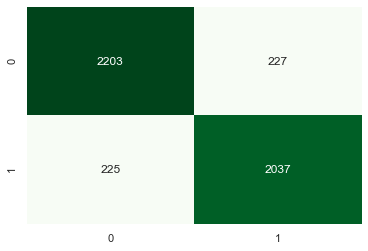

In [33]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');

I suppose big part of this mistakes is children. Let's see some examples where's model had made mistake.

In [34]:
y_pred = y_pred.reshape(y_pred.shape[0])

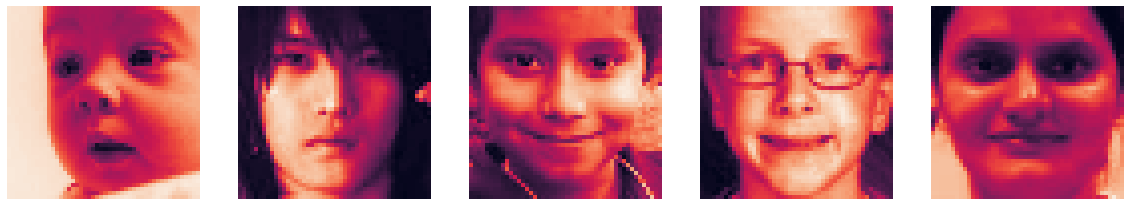

In [35]:
# Model predict is female, but actually it's male

X_fp = X_test[(y_pred == 1) & (y_test == 0)] 

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    
    random_choice = np.random.choice(len(X_fp))
    
    axes[i].imshow(X_fp[random_choice].reshape(48, 48))
    axes[i].axis('off')

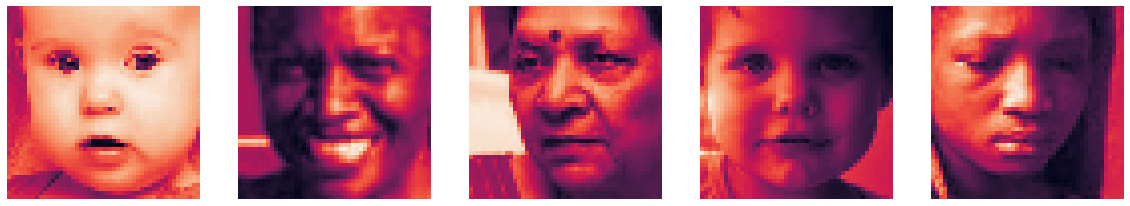

In [36]:
# Model predict is male, but actually it's female

X_fn = X_test[(y_pred == 0) & (y_test == 1)]  

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    
    random_choice = np.random.choice(len(X_fn))
    axes[i].imshow(X_fn[random_choice].reshape(48, 48))
    axes[i].axis('off')

So, on many photos difference between genders are not so clear.

## Ethnicity prediction

In [37]:
# Set y
y = df['ethnicity'].values

# Multiclass problem transform to one_hot_encoding
y = to_categorical(y, 5)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [38]:
eth_model = Sequential()

eth_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(BatchNormalization())

eth_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(BatchNormalization())

eth_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(Dropout(0.5))
eth_model.add(BatchNormalization())

eth_model.add(Flatten())
eth_model.add(Dense(128, activation='relu'))
eth_model.add(Dropout(0.5))
eth_model.add(Dense(5, activation='softmax')) #For multiclass classification activation function is softmax 

eth_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #...and loss function is categorical_crossentropy

eth_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 10, 128)       512       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 256)        

In [39]:
# Callbacks for ethnicity model
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
             ReduceLROnPlateau(patience=2, verbose=1)]

In [40]:
history = eth_model.fit(X_train, y_train, 
                         epochs=n_epochs,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         validation_data=(X_test, y_test))

Epoch 1/25
294/294 [==============================] - 153s 520ms/step - loss: 1.1482 - accuracy: 0.5841 - val_loss: 4.0773 - val_accuracy: 0.4211 - lr: 0.0010
Epoch 2/25
294/294 [==============================] - 149s 507ms/step - loss: 0.8838 - accuracy: 0.6909 - val_loss: 1.5929 - val_accuracy: 0.4836 - lr: 0.0010
Epoch 3/25
294/294 [==============================] - 148s 505ms/step - loss: 0.7994 - accuracy: 0.7248 - val_loss: 0.7371 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 4/25
294/294 [==============================] - 149s 505ms/step - loss: 0.7307 - accuracy: 0.7483 - val_loss: 0.8284 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 5/25
294/294 [==============================] - 148s 505ms/step - loss: 0.6770 - accuracy: 0.7688 - val_loss: 0.7136 - val_accuracy: 0.7602 - lr: 0.0010
Epoch 6/25
294/294 [==============================] - 151s 513ms/step - loss: 0.6540 - accuracy: 0.7768 - val_loss: 0.6609 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 7/25
294/294 [==========================

In [41]:
valid_score = eth_model.evaluate(X_test, y_test, verbose=1)

147/147 [==============================] - 11s 74ms/step - loss: 0.5761 - accuracy: 0.8061


In [42]:
y_pred = eth_model.predict_classes(X_test)

In [43]:
# Convert to 0 to 4 scale 
y_test_labels = [np.argmax(i) for i in y_test]

In [44]:
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1976
           1       0.86      0.87      0.87       920
           2       0.86      0.87      0.87       640
           3       0.72      0.77      0.75       783
           4       0.45      0.12      0.19       373

    accuracy                           0.81      4692
   macro avg       0.74      0.71      0.71      4692
weighted avg       0.79      0.81      0.79      4692



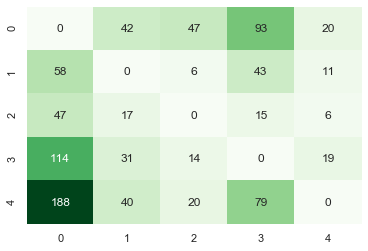

In [46]:
# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

np.fill_diagonal(cm, 0) #Fill diagonal with 0 for better visualisation
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greens');